## Regression Analysis: Regression with Regularization

### Overview

Machine Learning problem can be divided into two sub-categories -- **`Classification`** and **`Regression`** problem.
* **`Classification`** refers to the task of assigning labels *`(yes/no, True/False, Ham/Spam)`* to data samples belonging to different classes. 

It can either be a two-class classification problem (mostly using **sigmoid function**) or a multi-class classifcation problem (mostly using **softmax function**). 

* **`Regression`**, on the other hand, refers to the task of predicting continuous values (scalar) by depicting the relationship between dependent variables and various independent features.

`Linear Regression`, therefore, performs the task to predict a dependent variable value (y) based on a given independent variable (x) in a linear line. To find the line, **Ordinary Least Squared Method (OLS)** is widely used for regression problem. 

For complex problems, **`multivariate regression / Polynomial regression / Regularization term`** is utilized to enhance performance while at the same time restraining loss. 

While Linear Regression is the most loved regression models of all, it is not the most robust and rigid, and may present multiple problems.

In this notebook, we will take a look about a **`simple linear regression model`** as well as the topic of **`regularization`**.

In later notebook we will dive deeper into other forms of regression models.

---
### Notebook Setting

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

Here we will use the famous Boston Housing Dataset.

In [2]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()

boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['Target'] = boston_dataset.target
boston = boston[boston.columns[-1:].append(boston.columns[:-1])]
boston.head()

,Target,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
boston.isnull().values.any()

False

**No null value is detected. It's good to go!**

---
### Linear Regression

A normal linear regression is a statistical method that models the relationship between variables. In regression, it is believed that the relationship between two variables can be explained by the formula:

<img src='pic/lr.png' width="200" height="100">

<img src='pic/error.png' width="400" height="150">

* $ε_i$: the error term between the line and the data point

* $\alpha$ : intercept of the regression time. 

* $\beta$ : coefficient of the variable. It represents the variation of the dependent variable when the independent variable changes.

* $\alpha$, $\beta$ : are the unobserved parameters that we want to retrieve from this regression model.

An ordinary least squares model tends to fit the training data pretty well, but this nature makes the model less flexible to unknown dataset. Therefore, the model will have a low accuracy for testing dataset if it overfits on the training data. We will see how to deal with overfitting with regularization later in this notebook.

### Loss Function

To evaluate the performance of the regression model, various loss functions are introduced and are preferred in different scenario.

<img src='pic/loss_all.png' width="400" height="150">

In [77]:
def mse(pred, y_test):
    sum_err = 0.0
    y = y_test.values
    for i in range(len(y_test)):
        err = pred[i] - y[i]
        sum_err += (err**2)
    return(sum_err / float(len(pred)))

We will first **`MSE (Mean Squared Error)`** to evaluate the practice toy example below. At the end of this notebook, we will dive deeper into difference loss function / metrics as well as their respective strength and weaknesses.

### Preparation

In [4]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split

In [78]:
X = boston.drop(columns=['Target'])
y = boston['Target']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Linear Regression from Scratch

One approch to solve linear regression problem is to get the closed-form solution as below:

<img src='pic/closedform.png' width="200" height="100">

In [89]:
class LinearRegression:
    def __init__(self, fit_intercept = True, lr = 0.00000001,  n_iter = int(1e5)):
        """
        Initialize trhe calss
        fit_intercept: Boolean switch to indicate whether 
                       to include an intercept in the model.
        """
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
        self.n_features = X.shape[1]
        self.n_samples = len(y)
        self.n_iter = n_iter
        self.lr = lr
        self.X = np.hstack((np.ones((self.n_samples, 1)), # initialize the bias term
                            (X - np.mean(X, 0)) / np.std(X, 0))) # z-score
        self.y = y[:, np.newaxis] # 
        self.params = np.random.random((X.shape[1] + 1, 1)) / 10 # randomize coefficients

    def __repr__(self): # show discription when called
        return "I am a Linear Regression model!"
    
    def fit(self, X, y):
        """
        Fit model coefficients. Here we use the closed-form solution method.
        
        Arguments:
        X: 1D or 2D numpy array
        y: 1D numpy array
        """      
        
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

        # add bias if fit_intercept is True
        if self._fit_intercept:
            X_biased = np.c_[np.ones(X.shape[0]), X]
        else:
            X_biased = X

        # closed-form solution
        xTx = np.dot(X_biased.T, X_biased)
        inverse_xTx = np.linalg.inv(xTx)
        xTy = np.dot(X_biased.T, y)
        self.params = np.dot(inverse_xTx, xTy)

        # set attributes
        if self._fit_intercept:
            self.intercept_ = self.params[0]
            self.coef_ = self.params[1:]
    
    def predict(self, X):
        """
        Output model prediction.
        
        Arguments:
        X: 1D or 2D numpy array.
        """
        
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        
        self.predicted_ = self.intercept_ + np.dot(X, self.coef_)
        return(self.predicted_)

In [91]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

In [92]:
print(f'The coefficients are {mlr.coef_}.')

The coefficients are [-8.06537482e-02  5.07735518e-02  2.61950157e-02  4.54049650e+00
 -2.05361707e+01  5.11812583e+00 -1.23361131e-03 -1.44730255e+00
  2.95779411e-01 -1.33499164e-02 -8.35415154e-01  7.69524555e-03
 -4.16275041e-01].


In [93]:
print(f'The intercept for this regression line is {mlr.intercept_}.')

The intercept for this regression line is 27.12178800811307.


In [94]:
pred = mlr.predict(X_test)

In [95]:
result = {}
result['Custom Linear Regression'] = mse(pred, y_test)

Let's create another benchmark using the sklearn built-in linear regression model.

In [96]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)

In [97]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [98]:
lr_pred = lr.predict(X_test)

In [99]:
mse(lr_pred, y_test)

29.516015953838643

In [100]:
result['Sklearn Linear Regression'] = mse(lr_pred, y_test)

### Why Regularization is important?

One common problem in machine learning is overfitting, where a model fail to generalize and capture too much **noise** from the training data, meaning those information that cannot represent the true nature of the data, from your training data.

<img src="pic/overfit.gif" width="400" height="400">

This problem can further lead us to the topic of bias-variance tradeoff. For each machine learning models, the error comes from either bias or variance of the model.

<img src="pic/biasvar.jpg" width="300" height="300">

**`Bias`** refers to the correctness of the model's prediction. High bias means that the center of the predictions is way off target, while low bias indicates the center of those predictions to be near the target.

**`Variance`**, on the other hand, refers to how much a prediction could potentially vary if one of the variable changes. This metrics also depends on the number of samples. 

<img src="pic/bvex.png" width="600" height="300">

The **`low-bias, high-variance`** model often indicates overfitting, which means that the model learns too much from the training data that it even captures **noise** that is not part of the characteristic of the data, thus producing more errors when testing on the testing data. Error can even grow exponentially if the model overfits the training data too much.

The **`high-bias, low-variance`** model, on the other hand, exhibits underfitting, which means that the model doesn't learn much from the traninig data, thereby creating a "way too simple" model that can only capture few property of the dataset. 

Neither of those two above is ideal, and it's really important to strike a balance between bias and variance to find a good fit for the dataset.

<img src="pic/bv.png" width="340" height="300">

In general, **the more complex the model is, the lower the error comes from bias but the higher the error comes from variance.**

Therefore, we need to look for the optimal complexity of the solution in which total error (bias + variance + error) is minimized.

One robust approach do deal with overfitting is **`Regularization`**. It is a technique that eliminates the extent of overfitting by adding a penalty term, which is related to the coefficients, to the loss function. By doing so, the variance of the model is reduced since the curve will be smoother(smaller coefficients), and thus the model can generalize to other similar but not identical dataset. 

The model generalizes by shrinking the coefficient to a small value. Therefore,  **it encourages the model to be smoother and discourages a more complex model so as to avoid the risk of overfitting**. 

In the following we will introduce three kinds of regression model that combine regularization -- **`Lasso Regression, Ridge Regression, and Elastic Net Regression`**.

---
### L2 Regularization (aka. Ridge Regression)
L2 Regulazation, by its name, penalizing high coefficients using squared terms. It adds **squared magnitude** of coefficient multiplied by a constant $\lambda$ as the penalty term to the loss function. The formula below indicates cost that we want to minimize.

<img src="pic/ridge.png" width="600" height="400">

The `sum of squares of weights` term is also called the `shrinkage quantity`, and should be minimized to get a smoother line that are not affected too much by noise. Therefore, the coefficient of each variabe should be closed to small. Notice that we are not minimizing the intercept term in this case. 

The $\lambda$ term is the parameter that determines how much we want to penalize the high coefficients. **As the value of $\lambda$ increases, the coefficient is reduced and so is the variance**. The lower of variance, the lesser the possibility that overfitting occurs.  

In general, **The lower the $\lambda$, the closer it is to the ordinary least squares method. The higher the $\lambda$, the lower the coefficients will be, and the flatter the line will be.**

An overly high $\lambda$ can also result in underfitting of the model, as now the coefficient becomes "too regularized" that cannot show the relationship and start to loose important information regarding the relationship of target and varibles. **Therefore, tuning the value of $\lambda$ is a critical problem be be aware of.**

In [101]:
ridge = RidgeCV(alphas=(0.1, 1.0, 10.0), normalize=True, cv = 5)

The `alphas` variable indicates the array of regularization coefficients $\lambda$ to try. Larger values specify stronger regularization.

Also note that normalizing your numerical data before feeding into the model is always great habit. You can do this simply by setting `normalize = True`.

In [102]:
ridge.fit(X_train,y_train)
ridge_pred = ridge.predict(X_test)

In [104]:
mse(ridge_pred,y_test)

29.21889868668662

In [103]:
result['Ridge Regression'] = mse(ridge_pred,y_test)

Beware that **Ridge Regression is useful for the grouping effect, as colinear features will be selected together**.

### L1 Regularization (aka. Lasso Regression )

L1 Regularization, by its name, uses absolute value in penalizing high coefficients. It adds the **absolute magnitude** of coefficient multiplied by a constant $\lambda$ as the penality term to the loss function. This additional term penalizes the model for having coefficients that do not explain a sufficient amount of variance in the data. 

If $\lambda$ shrinks to zero, the regression model will become an ordinary least squares model. On the other hand, if $\lambda$ increases to infinity, coefficients will lean toward zero and the model will be the constant, baseline model with only the intercept.

One key difference is that **L1 regularization shrinks the coefficient of the less important feature to zero more quickly than L2 regularization**. Therefore, it's also used as a technique in selecting features that are not important for the regression model.

<img src="pic/lasso.png" width="600" height="400">

In [105]:
lasso = LassoCV(normalize=True, cv = 5)

In [106]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [107]:
mse(lasso_pred,y_test)

29.476824399012937

In [108]:
result['Lasso Regression'] = mse(lasso_pred,y_test)

Lasso, however, struggles with dataset that has more variables(features) than observations(n). In this case, **Lasso will pick at most n predictors as non-zero, even if all predictors are relevant**. 

Lasso also has difficulty in dealing with colinear features. **It will randomly choose one feature to represent the full suite of correlated features, which is bad for interpretation**. Beware to take a look at assumptions for linear models and deal with the problems before implementing algorithms!

### L1 Regularization as a Feature Selection Tool

Lasso regression is also widely used in feature selection, since it can shrink the coeffiecient of non-important features to zero.

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [110]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [111]:
selector = SelectFromModel(LassoCV())
selector.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [112]:
selector.get_support()

array([ True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True])

If **`return == 'True'`**, it means that the variable is **important (will not shrink to zero.)**


If **`return == 'False'`**, it means that the variable is **not important and will shrink to zero!**

If the coefficient of the variable shrinks to zero, we can drop those features.

---
### Comparison Between L1 and L2 Regularization

The image below shows the shrinkage quantity function (green areas) for L1 Regularization (left) and L2 Regularization (right), along with contours for the RSS (red contours). The intersection between two two figures are the estimated coefficients.

<img src="pic/reg.png" width="600" height="400">

For L1 Regularization (left), we can easily see that the two figures will often intersect on the four vertices (at least more commmon than L2 Regularization). Hence, **L1 Regularization can quickly shrink the coefficient estimates to zero**.

Regarding L2 Regularization (right), since the shrinkage quantity function has a circular areas, there's no vertices and thus will  generally not intersect on the x and y axes. Therefore, **L2 Regularization will hardly produce zero coefficient estimates**.

Generally speaking, **Lasso Regression cares about driving large coefficients down to small ones, or driving small ones to zero.**

However, **Ridge Regression gives small but well distributed coefficients, and thus cares more about driving large coefficients down to small ones**.

Meanwhile, according to the research by [(Hou, Hastie, 2005)](https://web.stanford.edu/~hastie/Papers/B67.2%20%282005%29%20301-320%20Zou%20&%20Hastie.pdf), neither Lasso nor Ridge is consistently better than the other; one should try both methods to determine which to use.

---
### Elastic Net Regression

To capture the benefit of both L1 and L2 Regularization, Elastic Net Regression is invented by combining penalty terms for the two regularization. It has been found to have **better predictive power than Lasso while preserving the feature selection effects**.

The Elastic Net, however, comes with additional burden of determining two $\lambda$ values for the two penalizing term.

<img src='pic/en.png' width=400 height=300>

In [113]:
elas = ElasticNetCV(normalize=True, cv = 5)

In [114]:
elas.fit(X_train, y_train)
elas_pred = elas.predict(X_test)

In [115]:
mse(elas_pred, y_test)

29.25614124947151

In [116]:
result['Elastic Net'] = mse(elas_pred, y_test)

### Model Performance

In [117]:
for i, j in result.items():
    print(f'Mean Squared Error of {i}: {j:0.4}')

Mean Squared Error of Custom Linear Regression: 29.52
Mean Squared Error of Sklearn Linear Regression: 29.52
Mean Squared Error of Ridge Regression: 29.22
Mean Squared Error of Lasso Regression: 29.48
Mean Squared Error of Elastic Net: 29.26


In this example, we can see that Ridge Regression was the best model based on the MSE metric.

From the dictionary above we still cannot see important advantages of **Lasso and Ridge Regression**. However, it's not saying that these models are not worth taking a look. The idea of which model to use depends on your goal of analysis. 

In later example, we will use **`Polynomial Linear Regression`** to demonstrate how L1 and L2 differs in terms of coefficient shrinkage.

### Let's compare the result with polynomial features!

In [118]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

For simplicity, let's assume that the order of coefficients in the model can grow up to the power of five.

For polynomial coefficients, the order is `['intercept', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', .....] `

Thus, we will retrieve the coef for the 13 variables with slicer `[1:14]`

In [135]:
poly = np.arange(1,6)
def regression(poly, model_string):
    
    if model_string == 'linear':
        model = LinearRegression(normalize=True)
    elif model_string == 'lasso':
        model = LassoCV(normalize=True, cv = 5)
    elif model_string == 'ridge':
        model = RidgeCV(normalize=True, cv = 5, gcv_mode='auto')
    elif model_string == 'elastic':
        model = ElasticNetCV(normalize=True, cv = 5)
    else:
        model = False
    
    if model != False:
        err_set = []
        coef_set = []
        for i in poly:
            start = datetime.now()
            mod = Pipeline(steps=[    
            ('polynomial',PolynomialFeatures(i)),
            ('model',model)
            ])
            mod.fit(X_train, y_train)
            pred = mod.predict(X_test)
            error = mse(pred, y_test)
            coef = [np.round(i,2) for i in mod.named_steps['model'].coef_[1:boston.shape[1]]] # retrieve coef from model within the pipeline
            print(f"Power: {i} Error: {error:.4f} Time: {datetime.now() - start}")
            print(f"Coef: {coef}")
            err_set.append(error)
            coef_set.append(coef)
        return(err_set, coef_set)
    else:
        print('Please select model from "linear", "lasso", and "ridge".')

In [136]:
lin_err, lin_coef = regression(poly, 'linear')

Power: 1 Error: 29.5160 Time: 0:00:00.005113
Coef: [-0.08, 0.05, 0.03, 4.54, -20.54, 5.12, -0.0, -1.45, 0.3, -0.01, -0.84, 0.01, -0.42]
Power: 2 Error: 12.6007 Time: 0:00:00.015189
Coef: [3.52, 0.77, -5.63, 29.98, 244.19, 23.08, 0.58, -9.74, 3.22, -0.16, 5.17, -0.01, 1.76]
Power: 3 Error: 3697.3280 Time: 0:00:00.062793
Coef: [16.46, 0.52, -30.49, 20.98, 642.27, -330.74, 0.85, -98.15, 31.63, 0.55, -34.04, 4.84, 68.87]
Power: 4 Error: 554.3837 Time: 0:00:00.143530
Coef: [-1.92, 0.09, 0.43, -0.33, 61.53, 33.22, 0.46, 3.5, 0.63, -0.04, -3.48, 0.23, 5.22]
Power: 5 Error: 672.2697 Time: 0:00:00.491445
Coef: [-0.4, 0.05, 0.2, -0.18, 18.28, 11.2, 0.12, 0.82, 0.06, -0.02, -1.03, 0.04, 1.35]


In [137]:
lasso_err, lasso_coef = regression(poly, 'lasso')

Power: 1 Error: 29.4768 Time: 0:00:00.065956
Coef: [-0.07, 0.05, 0.0, 4.52, -19.2, 5.16, -0.0, -1.36, 0.24, -0.01, -0.82, 0.01, -0.41]
Power: 2 Error: 15.6276 Time: 0:00:00.591712
Coef: [-0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -1.94, 0.31, 0.0, 0.0, 0.0, 0.0]
Power: 3 Error: 16.5816 Time: 0:00:10.133637
Coef: [-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.65, 0.08, 0.0, -0.0, 0.0, 0.0]
Power: 4 Error: 19.1453 Time: 0:01:12.763025
Coef: [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.02, 0.0, -0.0, 0.0, -0.0]
Power: 5 Error: 20.3384 Time: 0:05:20.510831
Coef: [-0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0]


In [138]:
ridge_err, ridge_coef = regression(poly, 'ridge')

Power: 1 Error: 29.2189 Time: 0:00:00.045865
Coef: [-0.06, 0.03, -0.05, 4.47, -12.78, 5.03, -0.01, -1.02, 0.12, -0.01, -0.78, 0.01, -0.38]
Power: 2 Error: 21.4219 Time: 0:00:00.052882
Coef: [0.01, -0.0, 0.03, 0.46, -3.16, 1.99, 0.01, -0.2, 0.06, -0.0, -0.18, 0.0, -0.05]
Power: 3 Error: 16.2982 Time: 0:00:00.103358
Coef: [0.01, -0.01, 0.01, 0.01, 0.39, 1.05, 0.01, -0.17, 0.04, 0.0, -0.08, 0.0, 0.0]
Power: 4 Error: 18.9571 Time: 0:00:00.295718
Coef: [0.0, -0.0, -0.0, -0.0, -0.18, 0.38, 0.0, -0.03, 0.01, -0.0, -0.04, 0.0, -0.01]
Power: 5 Error: 16.8096 Time: 0:00:00.823987
Coef: [0.0, -0.0, -0.0, -0.03, -0.11, 0.25, 0.0, -0.02, 0.0, -0.0, -0.02, 0.0, -0.0]


In [139]:
en_err, en_coef = regression(poly, 'elastic')

Power: 1 Error: 29.2561 Time: 0:00:00.111256
Coef: [-0.05, 0.03, -0.05, 4.38, -11.2, 4.94, -0.01, -0.91, 0.09, -0.0, -0.76, 0.01, -0.37]
Power: 2 Error: 22.6874 Time: 0:00:00.396071
Coef: [0.0, 0.0, 0.02, 0.37, -3.52, 1.9, 0.0, -0.14, 0.05, -0.0, -0.21, 0.0, -0.05]
Power: 3 Error: 17.5214 Time: 0:00:15.503253
Coef: [0.02, -0.01, 0.02, 0.0, 0.86, 0.9, 0.01, -0.17, 0.04, 0.0, -0.05, 0.0, 0.0]
Power: 4 Error: 18.6138 Time: 0:01:39.092253
Coef: [-0.0, -0.0, -0.0, 0.0, -0.0, 0.5, 0.0, -0.03, 0.01, -0.0, -0.05, 0.0, -0.0]
Power: 5 Error: 20.7940 Time: 0:06:05.752075
Coef: [0.0, -0.0, 0.0, 0.0, -0.0, 0.27, 0.0, -0.02, 0.0, -0.0, -0.02, 0.0, -0.0]


In [140]:
dic = {}
dic['Linear'] = lin_err
dic['Lasso'] = lasso_err
dic['Ridge'] = ridge_err
dic['ElasticNet'] = en_err

Text(0, 0.5, 'MSE')

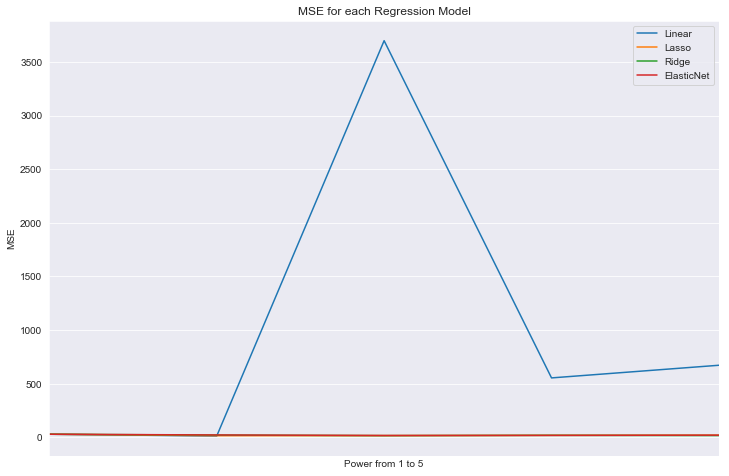

In [141]:
pd.DataFrame(dic).plot(figsize=(12,8))
plt.xticks([])
plt.title('MSE for each Regression Model')
plt.xlabel('Power from 1 to 5')
plt.ylabel('MSE')

From the plot above, we can easily see that normal Linear Regression model without regularization tends to create the most error due to overfitting to the training dataset.

Let's also see how the coefficients are like for each of the regression model.

In [174]:
col = ['coef1','coef2','coef3','coef4','coef5','coef6','coef7','coef8','coef9','coef10','coef11','coef12','coef13']

def coef_df(coef, col = col):
    dic = {}
    for i,v in enumerate(coef):
        dic[i] = v
    df = pd.DataFrame(dic, index=col).T
    df.index = range(1,6)
    
    return(df)

In [178]:
coef_df(lin_coef)

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
1,-0.08,0.05,0.03,4.54,-20.54,5.12,-0.00,-1.45,0.30,-0.01,-0.84,0.01,-0.42
2,3.52,0.77,-5.63,29.98,244.19,23.08,0.58,-9.74,3.22,-0.16,5.17,-0.01,1.76
3,16.46,0.52,-30.49,20.98,642.27,-330.74,0.85,-98.15,31.63,0.55,-34.04,4.84,68.87
4,-1.92,0.09,0.43,-0.33,61.53,33.22,0.46,3.50,0.63,-0.04,-3.48,0.23,5.22
5,-0.40,0.05,0.20,-0.18,18.28,11.20,0.12,0.82,0.06,-0.02,-1.03,0.04,1.35


In [179]:
coef_df(lasso_coef)

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
1,-0.07,0.05,0.0,4.52,-19.2,5.16,-0.0,-1.36,0.24,-0.01,-0.82,0.01,-0.41
2,-0.00,-0.00,0.0,0.00,-0.0,-0.00,0.0,-1.94,0.31,0.00,0.00,0.00,0.00
3,-0.00,-0.00,0.0,0.00,0.0,0.00,0.0,-0.65,0.08,0.00,-0.00,0.00,0.00
4,-0.00,-0.00,0.0,0.00,-0.0,0.00,0.0,-0.00,0.02,0.00,-0.00,0.00,-0.00
5,-0.00,0.00,0.0,0.00,-0.0,0.00,0.0,-0.00,0.00,0.00,-0.00,0.00,-0.00


In [180]:
coef_df(ridge_coef)

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
1,-0.06,0.03,-0.05,4.47,-12.78,5.03,-0.01,-1.02,0.12,-0.01,-0.78,0.01,-0.38
2,0.01,-0.00,0.03,0.46,-3.16,1.99,0.01,-0.20,0.06,-0.00,-0.18,0.00,-0.05
3,0.01,-0.01,0.01,0.01,0.39,1.05,0.01,-0.17,0.04,0.00,-0.08,0.00,0.00
4,0.00,-0.00,-0.00,-0.00,-0.18,0.38,0.00,-0.03,0.01,-0.00,-0.04,0.00,-0.01
5,0.00,-0.00,-0.00,-0.03,-0.11,0.25,0.00,-0.02,0.00,-0.00,-0.02,0.00,-0.00


In [181]:
coef_df(en_coef, col)

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
1,-0.05,0.03,-0.05,4.38,-11.20,4.94,-0.01,-0.91,0.09,-0.0,-0.76,0.01,-0.37
2,0.00,0.00,0.02,0.37,-3.52,1.90,0.00,-0.14,0.05,-0.0,-0.21,0.00,-0.05
3,0.02,-0.01,0.02,0.00,0.86,0.90,0.01,-0.17,0.04,0.0,-0.05,0.00,0.00
4,-0.00,-0.00,-0.00,0.00,-0.00,0.50,0.00,-0.03,0.01,-0.0,-0.05,0.00,-0.00
5,0.00,-0.00,0.00,0.00,-0.00,0.27,0.00,-0.02,0.00,-0.0,-0.02,0.00,-0.00


By comparison, we can see that at the polynomial of 3, most of the coefficients derived from lasso regression shrinks to zero and only two coefficients are still considered important, whereas in ridge regression, there are still small coefficients for most of the variables. Elastic Net Regression tends to be the middle the Lasso and Ridge regression.

We can also see why normal Linear Regression is not a good idea, as the coefficients significantly fluctuates, which demonstrates that the model has high variance due to overfitting to training dataset.

---
### End Note

Fro the [Sklearn algorithm cheatsheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), it is recommended to use **Lasso and ElasticNet** if only few features should be chosen given its nature of fast-shrinking to zero. If not, Ridge Regression is recommended. 

Generally speaking, **if you have lots of variables and have no idea about respective importance, or suspect that not all of them are important**, **you should give Lasso and ElasticNet a first shot**.

If the sample size is huge, the cheatsheet recommends taking a look at the **Stochastic Gradient Descent Regressor(SGDRegressor)**, which can also take in the idea of regularization via the parameter **`penalty`** and **`l1_ratio`**. 

The examples above explains the obvious advantage of Lasso Regression, as it can easily generalize a model with numerous features to a model containing few important features. This feature selection function is beneficial when you have a very complex dataset that contains hundreds or even thousands of features. If you choose Ridge Regression Model, chances are you will receive thousands of coefficients close to zero, but non of them will be zero. Therefore, the Ridge Regression Model will have a relatively worse model interpretability compared to Lasso Regression.

---
### Reference :
**Medium**:

[Linear Regression on Boston Housing Dataset](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)

[Object-oriented programming for data scientists: Build your ML estimator](https://towardsdatascience.com/object-oriented-programming-for-data-scientists-build-your-ml-estimator-7da416751f64)

[Multivariate Linear Regression from Scratch in Python](https://medium.com/@pytholabs/multivariate-linear-regression-from-scratch-in-python-5c4f219be6a)

[Regularization in Machine Learning](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)

[What’s the difference between Linear Regression, Lasso, Ridge, and ElasticNet in sklearn?](https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29)

[Feature Selection Using Regularisation](https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499)

[Bias, Variance, and Regularization in Linear Regression: Lasso, Ridge, and Elastic Net — Differences and uses](https://towardsdatascience.com/bias-variance-and-regularization-in-linear-regression-lasso-ridge-and-elastic-net-8bf81991d0c5)

**Others**:

[Derivation of the closed-form solution to minimizing the least-squares cost function](https://stats.stackexchange.com/questions/336860/derivation-of-the-closed-form-solution-to-minimizing-the-least-squares-cost-func)

[A Complete Tutorial on Ridge and Lasso Regression in Python](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)